In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd 

In [13]:
def imgshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5023, 0.5017, 0.5019])
    std = np.array([0.1245, 0.0934, 0.0581])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.axis("off")
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [14]:
img_size = (300, 300)
batch_size = 14
model_name = 'densenet121'
learning_rate = 0.001
num_epochs=50
nm_model = f'models/{model_name}_prep_e{num_epochs}_s{img_size[0]}_b{batch_size}'

In [15]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.5, contrast=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.5023, 0.5017, 0.5019], [0.1245, 0.0934, 0.0581])
    ]),
    'val': transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5023, 0.5017, 0.5019], [0.1245, 0.0934, 0.0581])
    ]),
    'test': transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5023, 0.5017, 0.5019], [0.1245, 0.0934, 0.0581])
    ])
}

data_dir = './data/data_m_prep'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

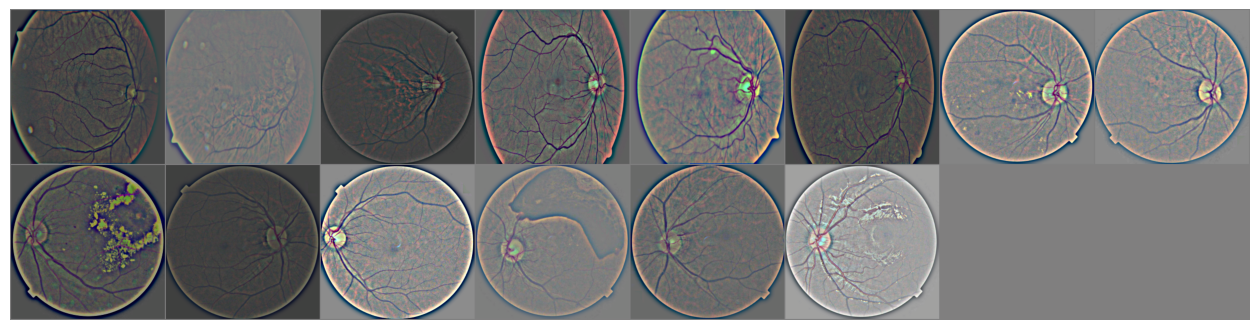

In [16]:
samples, labels = next(iter(dataloaders['train']))
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples)
imgshow(grid_imgs)

In [17]:
model_ft = torch.hub.load('pytorch/vision:v0.10.0', model_name, pretrained=True)
num_ftrs = model_ft.classifier.in_features

model_ft.classifier  = nn.Sequential(nn.Linear(num_ftrs, 500),nn.Linear(500,  len(class_names)))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# optimizer_ft = optim.SGD(model_ft.parameters(), lr=learning_rate, momentum=0.9)
optimizer_ft = optim.AdamW(model_ft.parameters(), lr=learning_rate)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Using cache found in C:\Users\micha/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\micha\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\micha\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    model_data = pd.DataFrame({'epoch number': [],
                               'train loss': [],
                               'validation loss': [],
                               'train accuracy': [],
                               'validation accuracy': [],
                               'test loss':[],
                               'test accuracy':[]})

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        model_data.at[epoch, 'epoch number'] = epoch+1
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, data in enumerate(dataloaders[phase], 0):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                pred = torch.argmax(outputs, dim=1)
                correct = pred.eq(labels)
                running_corrects += torch.sum(correct.float())
                torch.cuda.empty_cache() ####???????

            epoch_loss = running_loss  / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            if phase == 'train':
                scheduler.step()
                model_data.at[epoch, 'train loss'] = epoch_loss
                model_data.at[epoch, 'train accuracy'] = epoch_acc.item()
            else:
                model_data.at[epoch, 'validation loss'] = epoch_loss
                model_data.at[epoch, 'validation accuracy'] = epoch_acc.item()                      
            plint = phase if phase == 'train' else 'valid'
            print(f'{plint} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    model_data.to_csv(nm_model+'_stats.csv', index=False)

    return model

In [19]:
def test_model(model):    
    was_training = model.training
    model.eval()
    test_acc = 0
    test_loss = 0
    for i, data in enumerate(dataloaders['test'], 0):
        samples, labels = data
        with torch.no_grad():
            
            samples, labels = samples.to(device), labels.to(device)
            output = model(samples)
            loss = criterion(output, labels)
            pred = torch.argmax(output, dim=1)
            correct = pred.eq(labels)
            test_loss += loss.item() * samples.size(0)
            test_acc += torch.sum(correct.float())
            torch.cuda.empty_cache()
            model.train(mode=was_training)
    los = test_loss/dataset_sizes['test']
    acc = test_acc/dataset_sizes['test']
    model_data = pd.read_csv(nm_model+'_stats.csv')
    index = len(model_data.axes[0])
    model_data.at[index, 'test loss'] = los
    model_data.at[index, 'test accuracy'] = acc.item()
    model_data.to_csv(nm_model+'_stats.csv', index=False)
    print('Testing Accuracy: {:.2f} %'.format(100*acc))

In [20]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs)
test_model(model_ft)

Epoch [1/50]
train Loss: 0.7323 Acc: 0.6919
valid Loss: 1.6926 Acc: 0.5963
Epoch [2/50]
train Loss: 0.4787 Acc: 0.7859
valid Loss: 0.4729 Acc: 0.7890
Epoch [3/50]
train Loss: 0.4206 Acc: 0.8146
valid Loss: 0.3301 Acc: 0.9083
Epoch [4/50]
train Loss: 0.3485 Acc: 0.8512
valid Loss: 0.4479 Acc: 0.8440
Epoch [5/50]
train Loss: 0.3308 Acc: 0.8616
valid Loss: 0.8994 Acc: 0.5872
Epoch [6/50]
train Loss: 0.3839 Acc: 0.8381
valid Loss: 0.3636 Acc: 0.8165
Epoch [7/50]
train Loss: 0.3028 Acc: 0.8956
valid Loss: 0.8210 Acc: 0.7064
Epoch [8/50]
train Loss: 0.2988 Acc: 0.8851
valid Loss: 0.3249 Acc: 0.8532
Epoch [9/50]
train Loss: 0.1838 Acc: 0.9295
valid Loss: 0.3038 Acc: 0.8807
Epoch [10/50]
train Loss: 0.1474 Acc: 0.9426
valid Loss: 0.2718 Acc: 0.9083
Epoch [11/50]
train Loss: 0.1877 Acc: 0.9217
valid Loss: 0.2644 Acc: 0.9083
Epoch [12/50]
train Loss: 0.1559 Acc: 0.9399
valid Loss: 0.2685 Acc: 0.8991
Epoch [13/50]
train Loss: 0.1398 Acc: 0.9504
valid Loss: 0.2876 Acc: 0.9083
Epoch [14/50]
train L

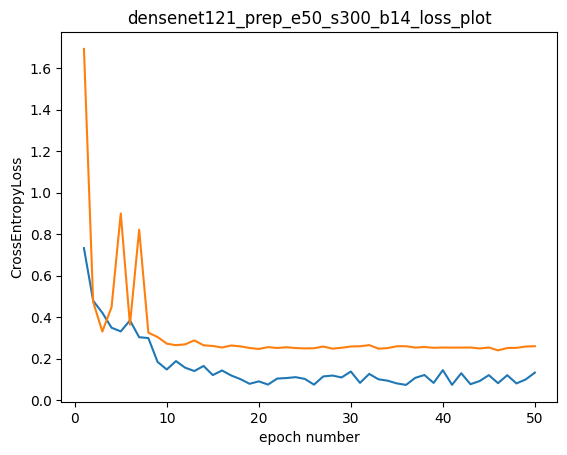

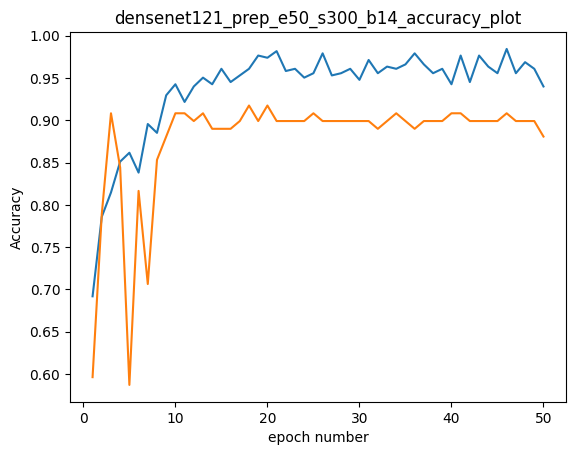

In [21]:
df = pd.read_csv(nm_model+'_stats.csv')

plt.plot(df['epoch number'],df['train loss'])
plt.plot(df['epoch number'],df['validation loss'])
plt.title(nm_model.split('/')[-1]+'_loss_plot')
plt.ylabel('CrossEntropyLoss')
plt.xlabel('epoch number')
plt.savefig(nm_model+'_loss_plot.jpg')
plt.show()
plt.plot(df['epoch number'],df['train accuracy'])
plt.plot(df['epoch number'],df['validation accuracy'])
plt.title(nm_model.split('/')[-1]+'_accuracy_plot')
plt.ylabel('Accuracy')
plt.xlabel('epoch number')
plt.savefig(nm_model+'_accuracy_plot.jpg')
plt.show()

In [22]:
torch.save(model_ft.state_dict(), nm_model+'.pt')

# model_ft = model_ft = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)
# num_ftrs = model_ft.classifier.in_features
# model_ft.classifier  = nn.Sequential(nn.Linear(num_ftrs, 500),nn.Linear(500,  len(class_names)))
# model_ft.load_state_dict(torch.load('models/densenet_100epochs_data_norm_randomCropRotation.pt'))

torch.cuda.empty_cache()